# Link Prediction using Graph Neural Networks
Predicts whether an edge exists between two particular nodes. e.g. social recommendation, item recommendation

The link prediction task here is formulated as a binary classification problem:
- Treat existing edges in the graph as *positive* examples
- Treat non-existing edges in the graph as *negative* examples
- Divide the *positive* and *negative* examples into  a training and test set
- Evaluate the model with Area Under Curve (AUC)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import pandas as pd
import scipy.sparse as sp


## Define GNN Model
GraphSAGE in this case

In [5]:
from dgl.nn import SAGEConv
import dgl.function as fn

In [6]:
# two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feats):
        h = self.conv1(g, in_feats)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

Use `DotPredictor` or `MLP` to compute new edge features based on the original node/edge features

In [8]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]
        
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

## PPI Dataset to Graph

In [12]:
import h5py
import time
import networkx as nx

In [13]:
seq = []
emb = []
emb_mean = []
with h5py.File("data/per-protein.h5", "r") as file:
    print(f"number of entries: {len(file.items())}")
    for sequence_id, embedding in file.items():
        seq.append(sequence_id)
        emb.append(embedding)
        emb_mean.append(np.array(embedding).mean())
        print(
            f"  id: {sequence_id}, "
            f"  embeddings shape: {embedding.shape}, "
            f"  embeddings mean: {np.array(embedding).mean()}"
        )

f = open('aso_data/homo_gene2acc_json.json')
gene_to_id = json.load(f)



number of entries: 20589
  id: A0A024R1R8,   embeddings shape: (1024,),   embeddings mean: -0.0029697418212890625
  id: A0A024RBG1,   embeddings shape: (1024,),   embeddings mean: -0.0006260871887207031
  id: A0A024RCN7,   embeddings shape: (1024,),   embeddings mean: 0.000583648681640625
  id: A0A075B6H5,   embeddings shape: (1024,),   embeddings mean: 0.00011861324310302734
  id: A0A075B6H7,   embeddings shape: (1024,),   embeddings mean: -0.0013294219970703125
  id: A0A075B6H8,   embeddings shape: (1024,),   embeddings mean: -0.0005736351013183594
  id: A0A075B6H9,   embeddings shape: (1024,),   embeddings mean: -0.00031948089599609375
  id: A0A075B6I0,   embeddings shape: (1024,),   embeddings mean: -0.0010690689086914062
  id: A0A075B6I1,   embeddings shape: (1024,),   embeddings mean: -0.0003833770751953125
  id: A0A075B6I3,   embeddings shape: (1024,),   embeddings mean: -0.0001932382583618164
  id: A0A075B6I4,   embeddings shape: (1024,),   embeddings mean: -0.00041890144348144

In [14]:
nf_dict= {}
for i, gene in enumerate(gene_to_id):
    gid = gene_to_id[gene]
    for j, s in enumerate(seq):
        if gid != '-':
            if s == gid:
                nf_dict[gene] = emb_mean[j]

In [15]:
ppi = pd.read_csv('context-PPI_final.csv').head(5000)

In [16]:
all_nodes = list(set(list(ppi['gene_a'].unique()) + list(ppi['gene_b'].unique())))

#### Create empty graph and add nodes

In [17]:
g = dgl.DGLGraph()
g.add_nodes(len(all_nodes))

/home/chen/dds/lib/python3.9/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


#### Give each unique gene an index so as to define edges from Gene A to Gene B

In [18]:
id_dict = {}
for i, gene in enumerate(all_nodes):
    id_dict[gene] = i

genea_idx = []
for i, gene in enumerate(ppi['gene_a']):
    for j, idx_match in enumerate(id_dict):
        if gene == idx_match:
            genea_idx.append(id_dict[idx_match])
geneb_idx = []
for i, gene in enumerate(ppi['gene_b']):
    for j, idx_match in enumerate(id_dict):
        if gene == idx_match:
            geneb_idx.append(id_dict[idx_match])


In [19]:
g.add_edges(torch.tensor(genea_idx).long(), torch.tensor(geneb_idx).long())

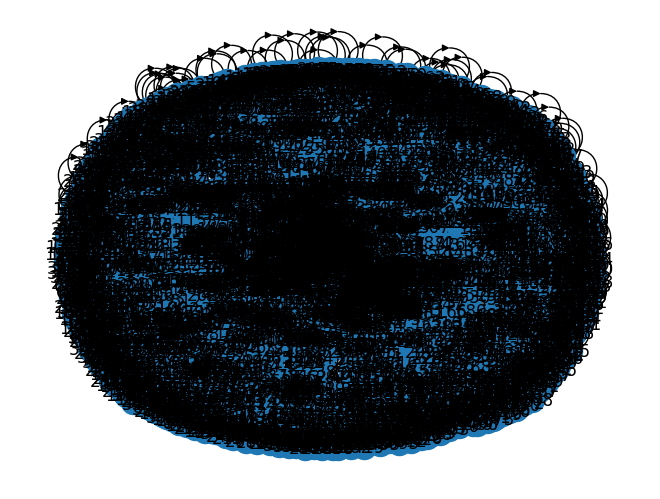

In [20]:
nx.draw(g.to_networkx(), with_labels = True)

#### Create Edge and Node Features
Initialize node features as zeros and use edge features to update them

In [21]:
cell_cat = torch.tensor(pd.get_dummies(ppi['cell_category']).values)
cell_sex = torch.tensor(pd.get_dummies(ppi['cell_sex']).values)
cell_spe = torch.tensor(pd.get_dummies(ppi['cell_species']).values)

In [22]:
ef = torch.cat([cell_cat, cell_sex, cell_spe], dim=-1).float()

In [23]:
feat = []
id_feat = []
ids = []
for i, gene_id in enumerate(id_dict.keys()):
    for j, gene_nf in enumerate(nf_dict.keys()): 
        if gene_nf == gene_id:
            feat.append([nf_dict[gene_nf]])
            id_feat.append([id_dict[gene_id], nf_dict[gene_nf]])
            ids.append(id_dict[gene_id])
            
node_remove = []
for i in range(len(all_nodes)):
    if i not in ids:
        node_remove.append(i)

In [24]:
no_nf = False
if no_nf:
    g.edata['feat'] = ef
    g.ndata['_feat'] = torch.zeros(g.num_nodes(), ef.size(1))
    node_dim = g.ndata['_feat'].size(1)
    edge_dim = g.edata['feat'].size(1)
    latent_dim = 5
    node_encoder = nn.Linear(node_dim, latent_dim)
    edge_encoder = nn.Linear(edge_dim, latent_dim)
    g.ndata['_h'] = node_encoder(g.ndata['_feat'])
    g.edata['_h'] = edge_encoder(g.edata['feat'])
    g.pull(g.nodes(),
        message_func=fn.copy_e('feat', 'm'),
        reduce_func=fn.sum('m', 'feat'))
else:
    g = dgl.remove_nodes(g, node_remove)
    g.ndata['feat'] = torch.tensor(feat).float()



In [25]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(g.number_of_nodes(), g.number_of_nodes()))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


In [26]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [27]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

## Train

In [28]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

In [29]:
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- training -------------------------------- #
all_logits = []
for e in range(50):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.6931453347206116
In epoch 5, loss: 0.6881474852561951
In epoch 10, loss: 0.6831523180007935
In epoch 15, loss: 0.6789045929908752
In epoch 20, loss: 0.6774188876152039
In epoch 25, loss: 0.6776207089424133
In epoch 30, loss: 0.6776547431945801
In epoch 35, loss: 0.6773513555526733
In epoch 40, loss: 0.6771327257156372
In epoch 45, loss: 0.6770969033241272
AUC 0.521450948479776
